# Fully Connected Artificial Neural Networks from scratch

#### This notebook implements neural network model with fully connected layers using only numpy
#### ---------------------------------------------------------------------------------------------------------------

This notebook demonstrates how fully connected neural network can be constructed without libraries such as PyTorch, Keras or Tensorflow which carry out most of the computations under the hood. This implementation is my won and I originally wrote to understand network models better while learning deep learning from various resources. Please note that the this neural network model is not suited for production but it should be consider as a learning resource.

## Dependencies

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Global Variables

In [2]:
run_training=True

## Toy Data

#### The implementation for toy data generator can be found from toydata.py file

In [3]:
from toydata import prepare_byte_data

The "prepare_byte_data"-method generetas toy data in binary representation. The reasoning behind using binary data to solve a toy problem is that each bit can be used as a separate input. This representation is better suited for the neural network than using only one integer value.

The format of the data is as follows:

In [4]:
sample_size = 5
sample_data = prepare_byte_data(sample_size,y_function = lambda x:2*x)
for i in range(len(sample_data)):
    print(f"{['Raw input', 'Input in binary form', 'True output y=2*x'][i]} is represented as:\n{sample_data[i]}\n")

Raw input is represented as:
[[155]
 [ 71]
 [ 11]
 [244]
 [134]]

Input in binary form is represented as:
[[1. 0. 0. 1. 1. 0. 1. 1.]
 [0. 1. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 0.]]

True output y=2*x is represented as:
[[310]
 [142]
 [ 22]
 [488]
 [268]]



## Activation funcitions

#### Implementations for the activation functions can be found from activation_functions.py

The following common activation functions are used in the toy problem
* Sigmoid
* ReLU

In [5]:
from activation_functions import sigmoid, relu, no_activation

## Fully connected layer

#### Implementation of the fully connected layer used in the model with methods for forward and backward computations 

Each layer has
* Wieght matrix, which includes the bias term if used. Weights will determine the output of the layer.
* Activation function, which will be set no activation by default. Activation is applied after to provide nonlinearity.
* Gradient matrix of the error with respect to weights (initialized to zero matrix)



In [6]:
class layer:
    def __init__(self,input_size,output_size,bias=True,activation=no_activation):
        
        # ---- Activation Function ----  
        self.activation = activation
        
        # ---- Bias ----
        self.bias = bias      
        if bias: input_size+=1
        
        # ---- Weights ----
        self.W = np.random.normal(0,1,(output_size,input_size))
        
        # ---- The gradient of the error with respect to weights ----
        self.dW = np.zeros((output_size,input_size))
    
    def forward(self,x):
        # if bias term is used, constant 1 is added to each input to represent bias
        if self.bias == True: x =  np.concatenate((x,np.ones((len(x),1))),axis=-1)
        
        # Input is saved for backward computations
        self.z = x
        
        # (W^T)X
        x = np.dot(x,np.transpose(self.W))
        
        # The activation is applied
        x = self.activation(x)
        
        return x
    
    def backward(self,dy,y):
        # Backpropagation
        d = dy*self.activation(y,derivate=True)
        dz = np.dot(d,self.W)
        
        # The gradient of the error with respect to the weight (for updating weights)
        self.dW += np.dot(np.transpose(d),self.z)
        
        # The bias can be omitted if used (lower layers don't need the information)
        if self.bias:
            return dz[:,:-1],self.z[:,:-1]
        return dz,self.z
    
    def update_weights(self,lr):
        self.W -= lr*self.dW
        self.dW = np.zeros(np.shape(self.W))
        

## Neural Network model with fully connected layers

In [7]:
class NN():
    def __init__(self):
        self.layers=[]
        self.N_layers = 0
    
    def forward(self,x):
        for n in range(self.N_layers):
            x = self.layers[n].forward(x)
        return x
    
    def backward(self,e,y):
        dy=-2*e
        for n in range(self.N_layers):
            dy,y = self.layers[-(n+1)].backward(dy,y)
            
    def update_weights(self,lr):
        for n in range(self.N_layers):
            self.layers[n].update_weights(lr)
        
    def add_layer(self,input_size,output_size,activation=no_activation,bias=True):
        try:
            new_layer = layer(input_size, output_size, activation=activation,bias=bias)
            self.layers.append(new_layer)
            self.N_layers+=1
        except:
            print("FAILURE")

## TEST 1  ||  y = 2x

In [8]:
input_size = 1
output_size = 1
    
batch_size = 20
epochs = 2000

#Learning for x**2
lr = 10**-8

true_function = lambda x:2*x

# Initiate Neural network and add input_layer, hidden layer and output layer
Net = NN()
Net.add_layer(input_size, output_size)

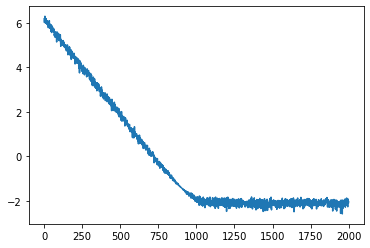

In [9]:
# Initiate error vector for plotting
errors = np.zeros(epochs)

for i in range(epochs):
    # Generate inputs
    x,x_bit,y = prepare_byte_data(batch_size, y_function = true_function)
    
    # Forward
    y_hat = Net.forward(x)
    
    #Error
    e = (y-y_hat)
    
    errors[i] = np.sqrt(np.sum(e**2)/batch_size)
    
    #backward
    Net.backward(e, y_hat)
    Net.update_weights(lr)
    
plt.plot(np.log(errors))
plt.show()

In [10]:
x_test,x_bit_test,y_test=prepare_byte_data(10, y_function = lambda x:2*x)
y_hat_test = Net.forward(x)
for i in range(0,10):
    print(f"#{i}: true = {y[i][0]}, guess = {y_hat[i][0]:.2f}")

#0: true = 168, guess = 167.88
#1: true = 68, guess = 67.80
#2: true = 256, guess = 255.94
#3: true = 114, guess = 113.84
#4: true = 496, guess = 496.11
#5: true = 124, guess = 123.84
#6: true = 502, guess = 502.12
#7: true = 380, guess = 380.03
#8: true = 218, guess = 217.91
#9: true = 192, guess = 191.89


In [11]:
for l in Net.layers:
    print(l.W)

[[ 2.00144678 -0.24595881]]


## TEST 2  ||  y  = x^2 

## Create a Neural Network model

In [12]:
input_size0 = 1
output_size0 = 1

input_size1 = 8
output_size1 = 1
hidden_size1 = 8



# Initiate Neural network and add input_layer, hidden layer and output layer
Net0 = NN()
Net0.add_layer(input_size0, output_size0)


# Initiate Neural network and add input_layer, hidden layer and output layer
Net1 = NN()
Net1.add_layer(input_size1, hidden_size1, activation = relu)
Net1.add_layer(hidden_size1, hidden_size1, activation = relu)
Net1.add_layer(hidden_size1, output_size1, activation = relu)

batch_size = 10
epochs = 2000


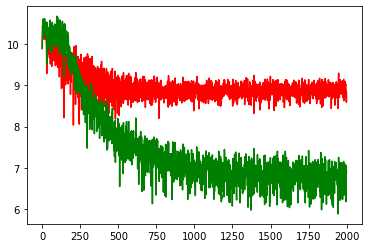

In [13]:
# Initiate error vector for plotting
errors0 = np.zeros(epochs)
errors1 = np.zeros(epochs)

lr0 = 10**-8
lr1 = 4*10**-9
true_function = lambda x:x**2

for i in range(epochs):
    # Generate inputs
    x,x_bit,y = prepare_byte_data(batch_size, y_function = true_function)
    
    # Forward
    y_hat0 = Net0.forward(x)
    y_hat1 = Net1.forward(x_bit)
    
    #Error    
    e0 = (y-y_hat0)
    e1 = (y-y_hat1)
    errors0[i] = np.sqrt( np.sum(e0**2)/batch_size )
    errors1[i] = np.sqrt( np.sum(e1**2)/batch_size )
    
    #backward
    Net0.backward(e0, y_hat0)
    Net0.update_weights(lr0)
    
    Net1.backward(e1, y_hat1)
    Net1.update_weights(lr1)

plt.plot(np.log(errors0),color='red')
plt.plot(np.log(errors1),color='green')
plt.show()

In [14]:
x_test, x_bit_test, y_test=prepare_byte_data(10, y_function = true_function)

y_hat_test0 = Net0.forward(x)
y_hat_test1 = Net1.forward(x_bit)
for i in range(0,10):
    print(f"#{i}: true = {y[i][0]}, model-0 prediction = {y_hat_test0[i][0]:.2f}, model-1 prediction = {y_hat_test1[i][0]:.2f}")

#0: true = 1, model-0 prediction = 190.08, model-1 prediction = 0.05
#1: true = 36, model-0 prediction = 1147.40, model-1 prediction = 1.26
#2: true = 37249, model-0 prediction = 36951.29, model-1 prediction = 38549.17
#3: true = 19600, model-0 prediction = 26803.66, model-1 prediction = 18443.37
#4: true = 61009, model-0 prediction = 47290.38, model-1 prediction = 58812.04
#5: true = 1225, model-0 prediction = 6699.87, model-1 prediction = 1205.85
#6: true = 24336, model-0 prediction = 29867.10, model-1 prediction = 24479.96
#7: true = 16129, model-0 prediction = 24314.62, model-1 prediction = 16550.93
#8: true = 29929, model-0 prediction = 33122.00, model-1 prediction = 30861.76
#9: true = 12769, model-0 prediction = 21634.12, model-1 prediction = 12770.74
